# Medical Appointment No-Show - Preprocessing & Feature Engineering

**Objectives:**
1. Handle missing values strategically
2. Fix data quality issues
3. Create powerful engineered features
4. Prepare datasets for modeling

**Input:** Raw data from EDA (109,593 rows)  
**Output:** Two clean, ML-ready datasets
- Classification dataset (patient-level features + no_show target)
- Time series dataset (daily aggregated appointment volumes)

**Key Decisions from EDA:**
- Age (20.9% missing) → Median imputation by specialty/gender
- Specialty (18.4% missing) → "Unknown" category
- Disability (15.1% missing) → "Unknown" category
- Place (10.5% missing) → "Unknown" category
- Weather (~2% missing) → Forward/backward fill
- Gender → Fix invalid "I" values
- Class imbalance (31.8% no-show) → Handle in modeling phase

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Utilities
import joblib
from datetime import datetime
import os

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✅ All libraries imported successfully!")
print(f"📅 Processing Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ All libraries imported successfully!
📅 Processing Date: 2026-02-02 14:17:53


In [2]:
# Load the raw data
df_raw = pd.read_csv('../data/raw/Medical_appointment_data.csv')

print("="*80)
print("📊 RAW DATA LOADED")
print("="*80)
print(f"\nShape: {df_raw.shape}")
print(f"Memory: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\n" + "="*80)

# Create a working copy
df = df_raw.copy()

print("\n✅ Working copy created - original data preserved")

📊 RAW DATA LOADED

Shape: (109593, 26)
Memory: 73.56 MB


✅ Working copy created - original data preserved


In [3]:
# Quick sanity check
print("="*80)
print("🔍 INITIAL DATA QUALITY CHECK")
print("="*80)

print(f"\n📋 Total Records: {len(df):,}")
print(f"📋 Total Features: {len(df.columns)}")
print(f"\n⚠️  Missing Data Summary:")

missing_summary = df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)

for col, count in missing_summary.items():
    pct = count / len(df) * 100
    print(f"   • {col}: {count:,} ({pct:.2f}%)")

print("\n" + "="*80)

🔍 INITIAL DATA QUALITY CHECK

📋 Total Records: 109,593
📋 Total Features: 26

⚠️  Missing Data Summary:
   • age: 22,960 (20.95%)
   • specialty: 20,127 (18.37%)
   • disability: 16,601 (15.15%)
   • place: 11,539 (10.53%)
   • max_rain_day: 2,263 (2.06%)
   • average_rain_day: 2,245 (2.05%)
   • max_temp_day: 2,227 (2.03%)
   • average_temp_day: 2,211 (2.02%)



## 1. Data Cleaning

**Tasks:**
1. Fix invalid gender values
2. Handle age outliers
3. Remove duplicates
4. Correct data types

In [4]:
print("="*80)
print("1️⃣ FIXING GENDER VALUES")
print("="*80)

# Check current gender distribution
print("\n📊 Before fixing:")
print(df['gender'].value_counts())

# Find invalid gender values
invalid_gender = df[~df['gender'].isin(['M', 'F'])]
print(f"\n⚠️  Invalid gender entries: {len(invalid_gender)}")

if len(invalid_gender) > 0:
    print(f"Invalid values: {invalid_gender['gender'].unique()}")
    
    # Strategy: Replace 'I' or other invalid values with most common gender
    most_common_gender = df['gender'].mode()[0]
    
    print(f"\n🔧 Replacing invalid values with most common: '{most_common_gender}'")
    df.loc[~df['gender'].isin(['M', 'F']), 'gender'] = most_common_gender
    
print("\n📊 After fixing:")
print(df['gender'].value_counts())
print("\n✅ Gender values cleaned")
print("="*80)

1️⃣ FIXING GENDER VALUES

📊 Before fixing:
gender
M    82269
F    27077
I      247
Name: count, dtype: int64

⚠️  Invalid gender entries: 247
Invalid values: ['I']

🔧 Replacing invalid values with most common: 'M'

📊 After fixing:
gender
M    82516
F    27077
Name: count, dtype: int64

✅ Gender values cleaned


In [5]:
print("="*80)
print("2️⃣ HANDLING AGE OUTLIERS")
print("="*80)

# Check age distribution
print("\n📊 Age Statistics (before cleaning):")
print(f"   Count (non-null): {df['age'].notna().sum():,}")
print(f"   Min: {df['age'].min()}")
print(f"   Max: {df['age'].max()}")
print(f"   Mean: {df['age'].mean():.2f}")
print(f"   Median: {df['age'].median():.2f}")

# Find outliers
negative_age = df[df['age'] < 0]
extreme_age = df[df['age'] > 120]

print(f"\n⚠️  Negative ages: {len(negative_age)}")
print(f"⚠️  Ages > 120: {len(extreme_age)}")

# Strategy: Set outliers to NaN (will be imputed later)
if len(negative_age) > 0 or len(extreme_age) > 0:
    print(f"\n🔧 Setting {len(negative_age) + len(extreme_age)} outliers to NaN for imputation")
    df.loc[df['age'] < 0, 'age'] = np.nan
    df.loc[df['age'] > 120, 'age'] = np.nan

print("\n📊 Age Statistics (after cleaning):")
print(f"   Count (non-null): {df['age'].notna().sum():,}")
print(f"   Min: {df['age'].min()}")
print(f"   Max: {df['age'].max()}")

print("\n✅ Age outliers handled")
print("="*80)

2️⃣ HANDLING AGE OUTLIERS

📊 Age Statistics (before cleaning):
   Count (non-null): 86,633
   Min: 2.0
   Max: 110.0
   Mean: 18.63
   Median: 12.00

⚠️  Negative ages: 0
⚠️  Ages > 120: 0

📊 Age Statistics (after cleaning):
   Count (non-null): 86,633
   Min: 2.0
   Max: 110.0

✅ Age outliers handled


In [6]:
print("="*80)
print("3️⃣ REMOVING DUPLICATE RECORDS")
print("="*80)

# Check for duplicates
duplicates = df.duplicated()
n_duplicates = duplicates.sum()

print(f"\n📊 Duplicate records found: {n_duplicates}")

if n_duplicates > 0:
    print(f"\n🔧 Removing {n_duplicates} duplicate records (keeping first occurrence)")
    df = df.drop_duplicates(keep='first')
    print(f"✅ Duplicates removed")
    print(f"📊 New dataset size: {len(df):,} rows")
else:
    print("\n✅ No duplicates found - data is clean")

print("\n" + "="*80)

3️⃣ REMOVING DUPLICATE RECORDS

📊 Duplicate records found: 36

🔧 Removing 36 duplicate records (keeping first occurrence)
✅ Duplicates removed
📊 New dataset size: 109,557 rows



In [7]:
print("="*80)
print("4️⃣ CONVERTING DATE COLUMN")
print("="*80)

# Convert appointment_date_continuous to datetime
print("\n🔧 Converting 'appointment_date_continuous' to datetime...")

df['appointment_date'] = pd.to_datetime(df['appointment_date_continuous'])

print(f"✅ Date conversion successful")
print(f"\n📅 Date Range:")
print(f"   Start: {df['appointment_date'].min()}")
print(f"   End: {df['appointment_date'].max()}")
print(f"   Total Days: {(df['appointment_date'].max() - df['appointment_date'].min()).days}")

print("\n" + "="*80)

4️⃣ CONVERTING DATE COLUMN

🔧 Converting 'appointment_date_continuous' to datetime...
✅ Date conversion successful

📅 Date Range:
   Start: 2020-01-01 00:00:00
   End: 2021-05-12 00:00:00
   Total Days: 497



## 2. Missing Value Imputation

**Strategy (from EDA):**
- **Age (20.9%):** Median by specialty + gender groups
- **Specialty (18.4%):** Create "Unknown" category
- **Disability (15.1%):** Create "Unknown" category
- **Place (10.5%):** Create "Unknown" category
- **Weather (~2%):** Forward fill then backward fill

In [8]:
print("="*80)
print("1️⃣ IMPUTING AGE (STRATEGIC APPROACH)")
print("="*80)

print(f"\n📊 Before imputation:")
print(f"   Missing age values: {df['age'].isnull().sum():,} ({df['age'].isnull().sum()/len(df)*100:.2f}%)")

# Calculate median age by specialty and gender
age_medians = df.groupby(['specialty', 'gender'])['age'].median()

print(f"\n🔧 Imputation Strategy: Median age by specialty + gender")
print(f"   Example medians:")
print(age_medians.head(10))

# Function to impute age
def impute_age(row):
    if pd.isna(row['age']):
        # Try to get median for this specialty + gender
        try:
            return age_medians.loc[(row['specialty'], row['gender'])]
        except KeyError:
            # If that combination doesn't exist, use overall median
            return df['age'].median()
    return row['age']

# Apply imputation
df['age'] = df.apply(impute_age, axis=1)

print(f"\n📊 After imputation:")
print(f"   Missing age values: {df['age'].isnull().sum():,}")
print(f"   Mean age: {df['age'].mean():.2f}")
print(f"   Median age: {df['age'].median():.2f}")

print("\n✅ Age imputation complete")
print("="*80)

1️⃣ IMPUTING AGE (STRATEGIC APPROACH)

📊 Before imputation:
   Missing age values: 22,929 (20.93%)

🔧 Imputation Strategy: Median age by specialty + gender
   Example medians:
specialty             gender
assist                F         19.0
                      M         18.0
enf                   F         57.0
                      M         38.0
occupational therapy  F         11.0
                      M         10.0
pedagogo              F         12.0
                      M         13.0
physiotherapy         F         18.0
                      M         18.0
Name: age, dtype: float64

📊 After imputation:
   Missing age values: 0
   Mean age: 17.54
   Median age: 12.00

✅ Age imputation complete


In [9]:
print("="*80)
print("2️⃣ HANDLING MISSING SPECIALTY")
print("="*80)

print(f"\n📊 Before:")
print(f"   Missing specialty: {df['specialty'].isnull().sum():,} ({df['specialty'].isnull().sum()/len(df)*100:.2f}%)")
print(f"   Unique specialties: {df['specialty'].nunique()}")

# Create "Unknown" category
print(f"\n🔧 Creating 'Unknown' category for missing specialties")
df['specialty'] = df['specialty'].fillna('Unknown')

print(f"\n📊 After:")
print(f"   Missing specialty: {df['specialty'].isnull().sum():,}")
print(f"   Unique specialties: {df['specialty'].nunique()}")
print(f"\n   Specialty distribution:")
print(df['specialty'].value_counts())

print("\n✅ Specialty missing values handled")
print("="*80)

2️⃣ HANDLING MISSING SPECIALTY

📊 Before:
   Missing specialty: 20,100 (18.35%)
   Unique specialties: 8

🔧 Creating 'Unknown' category for missing specialties

📊 After:
   Missing specialty: 0
   Unique specialties: 9

   Specialty distribution:
specialty
psychotherapy           28642
speech therapy          22321
physiotherapy           21001
Unknown                 20100
occupational therapy    11318
pedagogo                 3535
enf                      1681
assist                    635
sem especialidade         324
Name: count, dtype: int64

✅ Specialty missing values handled


In [10]:
print("="*80)
print("3️⃣ HANDLING MISSING DISABILITY")
print("="*80)

print(f"\n📊 Before:")
print(f"   Missing disability: {df['disability'].isnull().sum():,} ({df['disability'].isnull().sum()/len(df)*100:.2f}%)")

# Create "Unknown" category
print(f"\n🔧 Creating 'Unknown' category for missing disability")
df['disability'] = df['disability'].fillna('Unknown')

print(f"\n📊 After:")
print(f"   Missing disability: {df['disability'].isnull().sum():,}")
print(f"\n   Disability distribution:")
print(df['disability'].value_counts())

print("\n✅ Disability missing values handled")
print("="*80)

3️⃣ HANDLING MISSING DISABILITY

📊 Before:
   Missing disability: 16,571 (15.13%)

🔧 Creating 'Unknown' category for missing disability

📊 After:
   Missing disability: 0

   Disability distribution:
disability
intellectual    62847
motor           29720
Unknown         16571
                  419
Name: count, dtype: int64

✅ Disability missing values handled


In [11]:
print("="*80)
print("4️⃣ HANDLING MISSING PLACE/LOCATION")
print("="*80)

print(f"\n📊 Before:")
print(f"   Missing place: {df['place'].isnull().sum():,} ({df['place'].isnull().sum()/len(df)*100:.2f}%)")

# Create "Unknown" category
print(f"\n🔧 Creating 'Unknown' category for missing place")
df['place'] = df['place'].fillna('Unknown')

print(f"\n📊 After:")
print(f"   Missing place: {df['place'].isnull().sum():,}")
print(f"\n   Top 10 locations:")
print(df['place'].value_counts().head(10))

print("\n✅ Place missing values handled")
print("="*80)

4️⃣ HANDLING MISSING PLACE/LOCATION

📊 Before:
   Missing place: 11,509 (10.51%)

🔧 Creating 'Unknown' category for missing place

📊 After:
   Missing place: 0

   Top 10 locations:
place
ITAJAÍ            20512
Unknown           11509
B. CAMBORIU        6018
CAMBORIU           5523
NAVEGANTES         3901
ITAPEMA            2665
BOMBINHAS          1707
PENHA              1038
PORTO BELO          950
BALN. PIÇARRAS      943
Name: count, dtype: int64

✅ Place missing values handled


In [12]:
print("="*80)
print("5️⃣ HANDLING MISSING WEATHER DATA")
print("="*80)

weather_cols = ['average_temp_day', 'average_rain_day', 'max_temp_day', 'max_rain_day']

print(f"\n📊 Before:")
for col in weather_cols:
    missing = df[col].isnull().sum()
    print(f"   {col}: {missing} missing ({missing/len(df)*100:.2f}%)")

# Sort by date for forward/backward fill
df = df.sort_values('appointment_date').reset_index(drop=True)

print(f"\n🔧 Strategy: Forward fill, then backward fill (maintains temporal continuity)")

for col in weather_cols:
    df[col] = df[col].fillna(method='ffill').fillna(method='bfill')

print(f"\n📊 After:")
for col in weather_cols:
    missing = df[col].isnull().sum()
    print(f"   {col}: {missing} missing")

print("\n✅ Weather data imputation complete")
print("="*80)

5️⃣ HANDLING MISSING WEATHER DATA

📊 Before:
   average_temp_day: 2191 missing (2.00%)
   average_rain_day: 2225 missing (2.03%)
   max_temp_day: 2207 missing (2.01%)
   max_rain_day: 2243 missing (2.05%)

🔧 Strategy: Forward fill, then backward fill (maintains temporal continuity)

📊 After:
   average_temp_day: 0 missing
   average_rain_day: 0 missing
   max_temp_day: 0 missing
   max_rain_day: 0 missing

✅ Weather data imputation complete


## 3. Feature Engineering

**Creating 20+ new features to boost model performance:**

### Temporal Features (for both tasks)
- day_of_week, month, quarter, year
- week_of_year, day_of_month
- is_weekend, is_month_start, is_month_end

### Patient Features
- age_group (categorical bins)
- total_health_conditions
- has_any_condition

### Interaction Features
- specialty_place (combined)
- Health-based risk scores

### Aggregated Features
- Historical no-show rates by specialty/place

In [13]:
print("="*80)
print("🔧 FEATURE ENGINEERING - TEMPORAL FEATURES")
print("="*80)

print("\n1️⃣ Creating temporal features from appointment_date...")

# Extract temporal components
df['year'] = df['appointment_date'].dt.year
df['month'] = df['appointment_date'].dt.month
df['quarter'] = df['appointment_date'].dt.quarter
df['day_of_week'] = df['appointment_date'].dt.dayofweek  # Monday=0, Sunday=6
df['day_name'] = df['appointment_date'].dt.day_name()
df['week_of_year'] = df['appointment_date'].dt.isocalendar().week.astype(int)
df['day_of_month'] = df['appointment_date'].dt.day

# Binary temporal features
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)  # Saturday or Sunday
df['is_month_start'] = df['appointment_date'].dt.is_month_start.astype(int)
df['is_month_end'] = df['appointment_date'].dt.is_month_end.astype(int)

# Days since start (useful for time series)
df['days_since_start'] = (df['appointment_date'] - df['appointment_date'].min()).dt.days

print("✅ Temporal features created:")
temporal_features = ['year', 'month', 'quarter', 'day_of_week', 'day_name', 
                    'week_of_year', 'day_of_month', 'is_weekend', 
                    'is_month_start', 'is_month_end', 'days_since_start']
for feat in temporal_features:
    print(f"   • {feat}")

print("\n" + "="*80)

🔧 FEATURE ENGINEERING - TEMPORAL FEATURES

1️⃣ Creating temporal features from appointment_date...
✅ Temporal features created:
   • year
   • month
   • quarter
   • day_of_week
   • day_name
   • week_of_year
   • day_of_month
   • is_weekend
   • is_month_start
   • is_month_end
   • days_since_start



In [14]:
print("="*80)
print("2️⃣ CREATING AGE GROUP FEATURE")
print("="*80)

# Create age groups
df['age_group'] = pd.cut(df['age'], 
                         bins=[0, 12, 18, 40, 60, 120],
                         labels=['Child (0-12)', 'Teen (13-18)', 'Adult (19-40)', 
                                'Middle-Age (41-60)', 'Senior (60+)'],
                         include_lowest=True)

print("✅ Age groups created:")
print(df['age_group'].value_counts().sort_index())

# Verify consistency with existing flags
print("\n🔍 Validating age_group against existing flags:")
child_check = df[df['age_group'] == 'Child (0-12)']['under_12_years_old'].sum()
senior_check = df[df['age_group'] == 'Senior (60+)']['over_60_years_old'].sum()
print(f"   • Children with under_12_flag: {child_check}/{len(df[df['age_group'] == 'Child (0-12)'])}")
print(f"   • Seniors with over_60_flag: {senior_check}/{len(df[df['age_group'] == 'Senior (60+)'])}")

print("\n" + "="*80)

2️⃣ CREATING AGE GROUP FEATURE
✅ Age groups created:
age_group
Child (0-12)          61723
Teen (13-18)          25868
Adult (19-40)         10979
Middle-Age (41-60)     4766
Senior (60+)           6221
Name: count, dtype: int64

🔍 Validating age_group against existing flags:
   • Children with under_12_flag: 47015/61723
   • Seniors with over_60_flag: 5844/6221



In [15]:
print("="*80)
print("3️⃣ CREATING HEALTH CONDITION FEATURES")
print("="*80)

# Total health conditions
health_cols = ['Hipertension', 'Diabetes', 'Alcoholism', 'Handcap']
df['total_health_conditions'] = df[health_cols].sum(axis=1)

# Binary flag: has any condition
df['has_any_condition'] = (df['total_health_conditions'] > 0).astype(int)

print("✅ Health features created:")
print(f"\n   Distribution of total_health_conditions:")
print(df['total_health_conditions'].value_counts().sort_index())

print(f"\n   Patients with any condition: {df['has_any_condition'].sum():,} ({df['has_any_condition'].sum()/len(df)*100:.2f}%)")
print(f"   Patients with no conditions: {(1-df['has_any_condition']).sum():,} ({(1-df['has_any_condition']).sum()/len(df)*100:.2f}%)")

print("\n" + "="*80)

3️⃣ CREATING HEALTH CONDITION FEATURES
✅ Health features created:

   Distribution of total_health_conditions:
total_health_conditions
0    99007
1     9181
2     1268
3       99
4        2
Name: count, dtype: int64

   Patients with any condition: 10,550 (9.63%)
   Patients with no conditions: 99,007 (90.37%)



In [16]:
print("="*80)
print("4️⃣ CREATING INTERACTION FEATURES")
print("="*80)

# Specialty + Place interaction
df['specialty_place'] = df['specialty'] + '_' + df['place']

print("✅ Interaction features created:")
print(f"   • specialty_place: {df['specialty_place'].nunique()} unique combinations")
print(f"\n   Top 10 specialty-place combinations:")
print(df['specialty_place'].value_counts().head(10))

# Additional useful interactions
df['disability_age_group'] = df['disability'].astype(str) + '_' + df['age_group'].astype(str)
df['sms_shift'] = df['SMS_received'].astype(str) + '_' + df['appointment_shift']

print(f"\n   • disability_age_group: {df['disability_age_group'].nunique()} combinations")
print(f"   • sms_shift: {df['sms_shift'].nunique()} combinations")

print("\n" + "="*80)

4️⃣ CREATING INTERACTION FEATURES
✅ Interaction features created:
   • specialty_place: 41324 unique combinations

   Top 10 specialty-place combinations:
specialty_place
speech therapy_ITAJAÍ          5066
psychotherapy_ITAJAÍ           4787
physiotherapy_ITAJAÍ           4212
Unknown_Unknown                3769
occupational therapy_ITAJAÍ    2905
psychotherapy_Unknown          2435
Unknown_ITAJAÍ                 2371
physiotherapy_Unknown          2305
speech therapy_Unknown         1785
psychotherapy_B. CAMBORIU      1607
Name: count, dtype: int64

   • disability_age_group: 19 combinations
   • sms_shift: 4 combinations



In [17]:
print("="*80)
print("5️⃣ CREATING APPOINTMENT TIME BINS")
print("="*80)

# Bin appointment hours into meaningful categories
df['hour_category'] = pd.cut(df['appointment_time'], 
                             bins=[0, 9, 12, 15, 24],
                             labels=['Early Morning (6-9)', 'Morning (9-12)', 
                                   'Afternoon (12-15)', 'Late (15+)'],
                             include_lowest=True)

print("✅ Hour categories created:")
print(df['hour_category'].value_counts().sort_index())

print("\n" + "="*80)

5️⃣ CREATING APPOINTMENT TIME BINS
✅ Hour categories created:
hour_category
Early Morning (6-9)    33151
Morning (9-12)         17114
Afternoon (12-15)      38277
Late (15+)             21015
Name: count, dtype: int64



In [18]:
print("="*80)
print("6️⃣ CREATING HISTORICAL NO-SHOW RATE FEATURES")
print("="*80)

print("\n⚠️  Important: Creating these BEFORE train-test split to avoid data leakage")
print("    (In production, these would be calculated on training data only)")

# Convert no_show to numeric for calculations
df['no_show_numeric'] = (df['no_show'] == 'yes').astype(int)

# Historical no-show rate by specialty
specialty_noshow_rate = df.groupby('specialty')['no_show_numeric'].mean()
df['specialty_noshow_rate'] = df['specialty'].map(specialty_noshow_rate)

# Historical no-show rate by place
place_noshow_rate = df.groupby('place')['no_show_numeric'].mean()
df['place_noshow_rate'] = df['place'].map(place_noshow_rate)

# Historical no-show rate by disability
disability_noshow_rate = df.groupby('disability')['no_show_numeric'].mean()
df['disability_noshow_rate'] = df['disability'].map(disability_noshow_rate)

# Historical no-show rate by age group
age_group_noshow_rate = df.groupby('age_group')['no_show_numeric'].mean()
df['age_group_noshow_rate'] = df['age_group'].map(age_group_noshow_rate)

print("✅ Historical no-show rate features created:")
print(f"   • specialty_noshow_rate (by specialty)")
print(f"   • place_noshow_rate (by location)")
print(f"   • disability_noshow_rate (by disability type)")
print(f"   • age_group_noshow_rate (by age group)")

print("\n📊 Example values:")
print(f"   Specialty rates range: {df['specialty_noshow_rate'].min():.3f} to {df['specialty_noshow_rate'].max():.3f}")
print(f"   Place rates range: {df['place_noshow_rate'].min():.3f} to {df['place_noshow_rate'].max():.3f}")

print("\n" + "="*80)

6️⃣ CREATING HISTORICAL NO-SHOW RATE FEATURES

⚠️  Important: Creating these BEFORE train-test split to avoid data leakage
    (In production, these would be calculated on training data only)
✅ Historical no-show rate features created:
   • specialty_noshow_rate (by specialty)
   • place_noshow_rate (by location)
   • disability_noshow_rate (by disability type)
   • age_group_noshow_rate (by age group)

📊 Example values:
   Specialty rates range: 0.160 to 0.528
   Place rates range: 0.000 to 1.000



In [19]:
print("="*80)
print("7️⃣ CREATING BINARY WEATHER FLAGS")
print("="*80)

# Create binary flags for extreme weather
df['is_hot_day'] = (df['max_temp_day'] > 30).astype(int)  # > 30°C
df['is_cold_day'] = (df['average_temp_day'] < 15).astype(int)  # < 15°C
df['is_rainy_day'] = (df['average_rain_day'] > 0).astype(int)
df['is_heavy_rain'] = (df['max_rain_day'] > 5).astype(int)  # > 5mm

print("✅ Weather binary flags created:")
print(f"   • is_hot_day: {df['is_hot_day'].sum():,} hot days ({df['is_hot_day'].mean()*100:.1f}%)")
print(f"   • is_cold_day: {df['is_cold_day'].sum():,} cold days ({df['is_cold_day'].mean()*100:.1f}%)")
print(f"   • is_rainy_day: {df['is_rainy_day'].sum():,} rainy days ({df['is_rainy_day'].mean()*100:.1f}%)")
print(f"   • is_heavy_rain: {df['is_heavy_rain'].sum():,} heavy rain days ({df['is_heavy_rain'].mean()*100:.1f}%)")

print("\n" + "="*80)

7️⃣ CREATING BINARY WEATHER FLAGS
✅ Weather binary flags created:
   • is_hot_day: 7,699 hot days (7.0%)
   • is_cold_day: 7,749 cold days (7.1%)
   • is_rainy_day: 64,348 rainy days (58.7%)
   • is_heavy_rain: 12,286 heavy rain days (11.2%)



In [20]:
print("="*80)
print("📊 FEATURE ENGINEERING SUMMARY")
print("="*80)

print(f"\n✅ ORIGINAL FEATURES: {len(df_raw.columns)}")
print(f"✅ ENGINEERED FEATURES: {len(df.columns) - len(df_raw.columns)}")
print(f"✅ TOTAL FEATURES NOW: {len(df.columns)}")

print(f"\n🎯 NEW FEATURES CREATED:")

new_features = {
    'Temporal (11)': ['year', 'month', 'quarter', 'day_of_week', 'day_name', 
                      'week_of_year', 'day_of_month', 'is_weekend', 
                      'is_month_start', 'is_month_end', 'days_since_start'],
    'Patient (4)': ['age_group', 'total_health_conditions', 'has_any_condition', 'hour_category'],
    'Interactions (3)': ['specialty_place', 'disability_age_group', 'sms_shift'],
    'Historical Rates (4)': ['specialty_noshow_rate', 'place_noshow_rate', 
                            'disability_noshow_rate', 'age_group_noshow_rate'],
    'Weather Binary (4)': ['is_hot_day', 'is_cold_day', 'is_rainy_day', 'is_heavy_rain'],
    'Helper (2)': ['appointment_date', 'no_show_numeric']
}

for category, features in new_features.items():
    print(f"\n{category}:")
    for feat in features:
        print(f"   • {feat}")

print("\n" + "="*80)

📊 FEATURE ENGINEERING SUMMARY

✅ ORIGINAL FEATURES: 26
✅ ENGINEERED FEATURES: 28
✅ TOTAL FEATURES NOW: 54

🎯 NEW FEATURES CREATED:

Temporal (11):
   • year
   • month
   • quarter
   • day_of_week
   • day_name
   • week_of_year
   • day_of_month
   • is_weekend
   • is_month_start
   • is_month_end
   • days_since_start

Patient (4):
   • age_group
   • total_health_conditions
   • has_any_condition
   • hour_category

Interactions (3):
   • specialty_place
   • disability_age_group
   • sms_shift

Historical Rates (4):
   • specialty_noshow_rate
   • place_noshow_rate
   • disability_noshow_rate
   • age_group_noshow_rate

Weather Binary (4):
   • is_hot_day
   • is_cold_day
   • is_rainy_day
   • is_heavy_rain

Helper (2):
   • appointment_date
   • no_show_numeric



## 4. Encoding Categorical Variables

**Strategy:**
- **Binary variables:** Already 0/1 (no encoding needed)
- **Low cardinality (<10 categories):** One-Hot Encoding
- **High cardinality (>10 categories):** Label Encoding or keep for tree-based models

In [21]:
print("="*80)
print("🔤 CATEGORICAL VARIABLE ENCODING")
print("="*80)

# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove date columns and target
categorical_cols = [col for col in categorical_cols if col not in ['appointment_date_continuous', 'appointment_date', 'no_show', 'day_name']]

print(f"\n📋 Categorical columns to encode: {len(categorical_cols)}")

# Categorize by cardinality
low_cardinality = []
high_cardinality = []

for col in categorical_cols:
    n_unique = df[col].nunique()
    if n_unique <= 10:
        low_cardinality.append((col, n_unique))
    else:
        high_cardinality.append((col, n_unique))

print(f"\n📊 Low cardinality (≤10 unique, use One-Hot): {len(low_cardinality)}")
for col, n in low_cardinality:
    print(f"   • {col}: {n} categories")

print(f"\n📊 High cardinality (>10 unique, use Label Encoding): {len(high_cardinality)}")
for col, n in high_cardinality:
    print(f"   • {col}: {n} categories")

print("\n" + "="*80)

🔤 CATEGORICAL VARIABLE ENCODING

📋 Categorical columns to encode: 13

📊 Low cardinality (≤10 unique, use One-Hot): 10
   • specialty: 9 categories
   • gender: 2 categories
   • disability: 4 categories
   • appointment_shift: 2 categories
   • rain_intensity: 4 categories
   • heat_intensity: 5 categories
   • age_group: 5 categories
   • sms_shift: 4 categories
   • hour_category: 4 categories
   • age_group_noshow_rate: 5 categories

📊 High cardinality (>10 unique, use Label Encoding): 3
   • place: 26290 categories
   • specialty_place: 41324 categories
   • disability_age_group: 19 categories



In [22]:
print("="*80)
print("1️⃣ ONE-HOT ENCODING (Low Cardinality Features)")
print("="*80)

# Select low cardinality columns
low_card_cols = [col for col, _ in low_cardinality]

print(f"\n🔧 Applying One-Hot Encoding to: {low_card_cols}")

# Apply one-hot encoding
df_encoded = pd.get_dummies(df, columns=low_card_cols, prefix=low_card_cols, drop_first=True)

print(f"\n✅ One-Hot Encoding complete")
print(f"   Columns before: {len(df.columns)}")
print(f"   Columns after: {len(df_encoded.columns)}")
print(f"   New columns created: {len(df_encoded.columns) - len(df.columns)}")

# Update df
df = df_encoded.copy()

print("\n" + "="*80)

1️⃣ ONE-HOT ENCODING (Low Cardinality Features)

🔧 Applying One-Hot Encoding to: ['specialty', 'gender', 'disability', 'appointment_shift', 'rain_intensity', 'heat_intensity', 'age_group', 'sms_shift', 'hour_category', 'age_group_noshow_rate']

✅ One-Hot Encoding complete
   Columns before: 54
   Columns after: 78
   New columns created: 24



In [23]:
print("="*80)
print("2️⃣ LABEL ENCODING (High Cardinality Features)")
print("="*80)

# Select high cardinality columns
high_card_cols = [col for col, _ in high_cardinality if col in df.columns]

print(f"\n🔧 Applying Label Encoding to: {high_card_cols}")

# Initialize label encoders dictionary (save for later use)
label_encoders = {}

for col in high_card_cols:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    
    print(f"   ✓ {col}: {len(le.classes_)} classes → 0 to {len(le.classes_)-1}")

print(f"\n✅ Label Encoding complete")
print(f"   Encoders saved for: {list(label_encoders.keys())}")

print("\n" + "="*80)

2️⃣ LABEL ENCODING (High Cardinality Features)

🔧 Applying Label Encoding to: ['place', 'specialty_place', 'disability_age_group']
   ✓ place: 26290 classes → 0 to 26289
   ✓ specialty_place: 41324 classes → 0 to 41323
   ✓ disability_age_group: 19 classes → 0 to 18

✅ Label Encoding complete
   Encoders saved for: ['place', 'specialty_place', 'disability_age_group']



In [24]:
print("="*80)
print("3️⃣ ENCODING TARGET VARIABLE")
print("="*80)

# Target is already binary text: 'yes'/'no'
# Convert to 1/0 for modeling

print(f"\n📊 Before encoding:")
print(df['no_show'].value_counts())

df['no_show_binary'] = (df['no_show'] == 'yes').astype(int)

print(f"\n📊 After encoding (no_show_binary):")
print(df['no_show_binary'].value_counts())
print(f"\n   0 = Show, 1 = No-Show")

print("\n✅ Target variable encoded")
print("="*80)

3️⃣ ENCODING TARGET VARIABLE

📊 Before encoding:
no_show
no     74726
yes    34831
Name: count, dtype: int64

📊 After encoding (no_show_binary):
no_show_binary
0    74726
1    34831
Name: count, dtype: int64

   0 = Show, 1 = No-Show

✅ Target variable encoded


## 5. Creating Two ML-Ready Datasets

**Dataset 1: Classification (No-Show Prediction)**
- Patient-level records
- All engineered features
- Target: no_show_binary

**Dataset 2: Time Series (Demand Forecasting)**
- Daily aggregated appointment volumes
- Temporal features
- Target: Daily appointment count

In [25]:
print("="*80)
print("📊 FINAL DATA CHECK BEFORE DATASET CREATION")
print("="*80)

print(f"\n✅ Current dataset status:")
print(f"   Total records: {len(df):,}")
print(f"   Total features: {len(df.columns)}")
print(f"   Missing values: {df.isnull().sum().sum()}")

print(f"\n🎯 Target variable distribution:")
print(df['no_show_binary'].value_counts())
print(f"   No-show rate: {df['no_show_binary'].mean()*100:.2f}%")

print("\n" + "="*80)

📊 FINAL DATA CHECK BEFORE DATASET CREATION

✅ Current dataset status:
   Total records: 109,557
   Total features: 82
   Missing values: 0

🎯 Target variable distribution:
no_show_binary
0    74726
1    34831
Name: count, dtype: int64
   No-show rate: 31.79%



In [26]:
print("="*80)
print("📋 DATASET 1: CLASSIFICATION DATASET PREPARATION")
print("="*80)

# Define feature groups
print("\n🔧 Selecting features for classification model...")

# Features to EXCLUDE (non-predictive or redundant)
exclude_cols = [
    'appointment_date_continuous',  # String version of date
    'appointment_date',  # Datetime (already extracted features)
    'no_show',  # Original text target
    'no_show_numeric',  # Redundant with no_show_binary
    'day_name',  # String version (already have day_of_week)
    'year_month',  # If exists from EDA
]

# Features to INCLUDE
feature_cols = [col for col in df.columns if col not in exclude_cols and col != 'no_show_binary']

print(f"\n✅ Selected {len(feature_cols)} features for classification")

# Separate features and target
X_classification = df[feature_cols].copy()
y_classification = df['no_show_binary'].copy()

print(f"\n📊 Classification Dataset:")
print(f"   Features (X): {X_classification.shape}")
print(f"   Target (y): {y_classification.shape}")
print(f"   Target distribution: {y_classification.value_counts().to_dict()}")

print("\n" + "="*80)

📋 DATASET 1: CLASSIFICATION DATASET PREPARATION

🔧 Selecting features for classification model...

✅ Selected 76 features for classification

📊 Classification Dataset:
   Features (X): (109557, 76)
   Target (y): (109557,)
   Target distribution: {0: 74726, 1: 34831}



In [27]:
print("="*80)
print("🔍 FINAL MISSING VALUE CHECK")
print("="*80)

missing_in_X = X_classification.isnull().sum()
missing_features = missing_in_X[missing_in_X > 0]

if len(missing_features) > 0:
    print(f"\n⚠️  Warning: {len(missing_features)} features still have missing values:")
    for col, count in missing_features.items():
        print(f"   • {col}: {count} ({count/len(X_classification)*100:.2f}%)")
    
    print("\n🔧 Filling remaining missing values with median/mode...")
    
    # Fill numeric with median
    numeric_cols = X_classification.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if X_classification[col].isnull().sum() > 0:
            X_classification[col].fillna(X_classification[col].median(), inplace=True)
    
    # Fill categorical with mode
    categorical_cols = X_classification.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        if X_classification[col].isnull().sum() > 0:
            X_classification[col].fillna(X_classification[col].mode()[0], inplace=True)
    
    print(f"✅ All missing values handled")
else:
    print(f"\n✅ No missing values in classification dataset!")

print(f"\n📊 Final check: {X_classification.isnull().sum().sum()} missing values")
print("="*80)

🔍 FINAL MISSING VALUE CHECK

✅ No missing values in classification dataset!

📊 Final check: 0 missing values


In [28]:
print("="*80)
print("✂️ TRAIN-TEST SPLIT: CLASSIFICATION")
print("="*80)

print("\n🔧 Strategy: Stratified split (preserves class distribution)")
print("   Split: 80% train, 20% test")
print("   Random state: 42 (for reproducibility)")

# Perform stratified split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_classification, 
    y_classification,
    test_size=0.2,
    random_state=42,
    stratify=y_classification  # Maintains class balance
)

print(f"\n✅ Split complete:")
print(f"   Training set: {X_train_clf.shape[0]:,} samples ({X_train_clf.shape[0]/len(X_classification)*100:.1f}%)")
print(f"   Test set: {X_test_clf.shape[0]:,} samples ({X_test_clf.shape[0]/len(X_classification)*100:.1f}%)")

print(f"\n📊 Class distribution verification:")
print(f"   Original: {y_classification.value_counts(normalize=True).to_dict()}")
print(f"   Train: {y_train_clf.value_counts(normalize=True).to_dict()}")
print(f"   Test: {y_test_clf.value_counts(normalize=True).to_dict()}")

print("\n✅ Stratification successful - class balance maintained!")
print("="*80)

✂️ TRAIN-TEST SPLIT: CLASSIFICATION

🔧 Strategy: Stratified split (preserves class distribution)
   Split: 80% train, 20% test
   Random state: 42 (for reproducibility)

✅ Split complete:
   Training set: 87,645 samples (80.0%)
   Test set: 21,912 samples (20.0%)

📊 Class distribution verification:
   Original: {0: 0.6820741714358736, 1: 0.31792582856412643}
   Train: {0: 0.6820697130469507, 1: 0.31793028695304926}
   Test: {0: 0.682092004381161, 1: 0.317907995618839}

✅ Stratification successful - class balance maintained!


In [30]:
print("="*80)
print("📋 DATASET 2: TIME SERIES DATASET PREPARATION")
print("="*80)

print("\n🔧 Aggregating data by date for demand forecasting...")

# First, let's use the original df before encoding for aggregation
# We need to reload or use a copy we saved earlier

# Option 1: Use df_raw and apply only necessary cleaning
df_ts_prep = df_raw.copy()

# Apply date conversion
df_ts_prep['appointment_date'] = pd.to_datetime(df_ts_prep['appointment_date_continuous'])

# Convert no_show to binary
df_ts_prep['no_show_binary'] = (df_ts_prep['no_show'] == 'yes').astype(int)

# Extract temporal features we need
df_ts_prep['day_of_week'] = df_ts_prep['appointment_date'].dt.dayofweek
df_ts_prep['month'] = df_ts_prep['appointment_date'].dt.month
df_ts_prep['quarter'] = df_ts_prep['appointment_date'].dt.quarter
df_ts_prep['is_weekend'] = (df_ts_prep['day_of_week'] >= 5).astype(int)

# Create weather binary flags
df_ts_prep['is_hot_day'] = (df_ts_prep['max_temp_day'] > 30).astype(int)
df_ts_prep['is_cold_day'] = (df_ts_prep['average_temp_day'] < 15).astype(int)
df_ts_prep['is_rainy_day'] = (df_ts_prep['average_rain_day'] > 0).astype(int)

# Handle NaN in weather (simple fill for aggregation)
weather_cols = ['average_temp_day', 'average_rain_day', 'max_temp_day', 'max_rain_day']
for col in weather_cols:
    df_ts_prep[col] = df_ts_prep[col].fillna(method='ffill').fillna(method='bfill')

# Now aggregate by date
ts_data = df_ts_prep.groupby('appointment_date').agg({
    'no_show_binary': 'count',  # Total appointments per day (count all records)
    'average_temp_day': 'mean',
    'average_rain_day': 'mean',
    'max_temp_day': 'max',
    'max_rain_day': 'max',
    'day_of_week': 'first',
    'month': 'first',
    'quarter': 'first',
    'is_weekend': 'first',
    'is_hot_day': 'max',
    'is_cold_day': 'max',
    'is_rainy_day': 'max'
}).reset_index()

# Rename count column
ts_data.rename(columns={'no_show_binary': 'daily_appointments'}, inplace=True)

print(f"\n✅ Time series dataset created:")
print(f"   Shape: {ts_data.shape}")
print(f"   Date range: {ts_data['appointment_date'].min()} to {ts_data['appointment_date'].max()}")
print(f"   Total days: {len(ts_data)}")

print(f"\n📊 Daily appointments statistics:")
print(f"   Mean: {ts_data['daily_appointments'].mean():.1f}")
print(f"   Median: {ts_data['daily_appointments'].median():.1f}")
print(f"   Min: {ts_data['daily_appointments'].min()}")
print(f"   Max: {ts_data['daily_appointments'].max()}")
print(f"   Std: {ts_data['daily_appointments'].std():.1f}")

print("\n" + "="*80)

📋 DATASET 2: TIME SERIES DATASET PREPARATION

🔧 Aggregating data by date for demand forecasting...

✅ Time series dataset created:
   Shape: (498, 13)
   Date range: 2020-01-01 00:00:00 to 2021-05-12 00:00:00
   Total days: 498

📊 Daily appointments statistics:
   Mean: 220.1
   Median: 126.5
   Min: 1
   Max: 1512
   Std: 245.8



In [31]:
print("="*80)
print("🔧 TIME SERIES SPECIFIC FEATURES")
print("="*80)

print("\n1️⃣ Creating lag features...")

# Sort by date (critical!)
ts_data = ts_data.sort_values('appointment_date').reset_index(drop=True)

# Lag features (previous days' volumes)
ts_data['lag_1'] = ts_data['daily_appointments'].shift(1)  # Yesterday
ts_data['lag_7'] = ts_data['daily_appointments'].shift(7)  # Last week
ts_data['lag_30'] = ts_data['daily_appointments'].shift(30)  # Last month

print("   ✓ lag_1 (previous day)")
print("   ✓ lag_7 (same day last week)")
print("   ✓ lag_30 (same day last month)")

print("\n2️⃣ Creating rolling statistics...")

# Rolling mean (moving average)
ts_data['rolling_mean_7'] = ts_data['daily_appointments'].rolling(window=7, min_periods=1).mean()
ts_data['rolling_mean_30'] = ts_data['daily_appointments'].rolling(window=30, min_periods=1).mean()

# Rolling std (volatility)
ts_data['rolling_std_7'] = ts_data['daily_appointments'].rolling(window=7, min_periods=1).std()

print("   ✓ rolling_mean_7 (7-day moving average)")
print("   ✓ rolling_mean_30 (30-day moving average)")
print("   ✓ rolling_std_7 (7-day volatility)")

print("\n3️⃣ Creating trend feature...")
ts_data['days_since_start'] = (ts_data['appointment_date'] - ts_data['appointment_date'].min()).dt.days

print("   ✓ days_since_start (linear trend)")

print(f"\n✅ Time series features complete")
print(f"   Total features: {len(ts_data.columns)}")

print("\n" + "="*80)

🔧 TIME SERIES SPECIFIC FEATURES

1️⃣ Creating lag features...
   ✓ lag_1 (previous day)
   ✓ lag_7 (same day last week)
   ✓ lag_30 (same day last month)

2️⃣ Creating rolling statistics...
   ✓ rolling_mean_7 (7-day moving average)
   ✓ rolling_mean_30 (30-day moving average)
   ✓ rolling_std_7 (7-day volatility)

3️⃣ Creating trend feature...
   ✓ days_since_start (linear trend)

✅ Time series features complete
   Total features: 20



📈 TIME SERIES VISUALIZATION


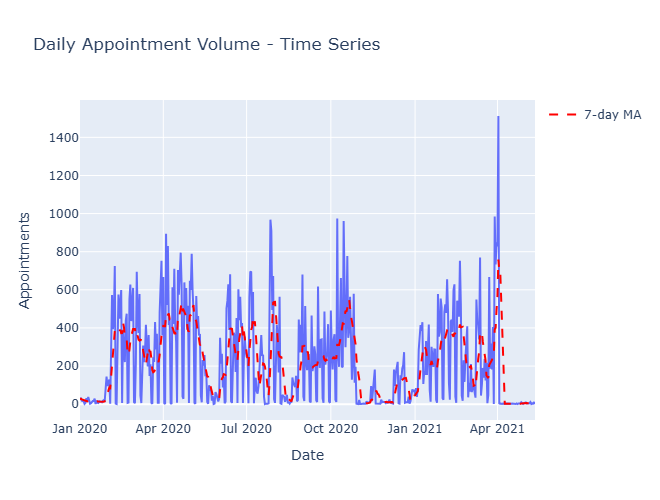


💡 Look for trends, seasonality, and anomalies


In [32]:
print("="*80)
print("📈 TIME SERIES VISUALIZATION")
print("="*80)

# Plot the time series
fig = px.line(ts_data, 
              x='appointment_date', 
              y='daily_appointments',
              title='Daily Appointment Volume - Time Series',
              labels={'appointment_date': 'Date', 'daily_appointments': 'Appointments'})

fig.add_scatter(x=ts_data['appointment_date'], 
                y=ts_data['rolling_mean_7'],
                mode='lines',
                name='7-day MA',
                line=dict(color='red', dash='dash'))

fig.update_layout(height=500)
fig.show()

print("\n💡 Look for trends, seasonality, and anomalies")
print("="*80)

In [33]:
print("="*80)
print("✂️ TRAIN-TEST SPLIT: TIME SERIES")
print("="*80)

print("\n🔧 Strategy: Chronological split (NO shuffling!)")
print("   Split: First 80% = Train, Last 20% = Test")
print("   Critical: Future data cannot leak into training!")

# Calculate split point
split_idx = int(len(ts_data) * 0.8)
split_date = ts_data.iloc[split_idx]['appointment_date']

# Split chronologically
ts_train = ts_data.iloc[:split_idx].copy()
ts_test = ts_data.iloc[split_idx:].copy()

print(f"\n✅ Split complete:")
print(f"   Training set: {len(ts_train)} days ({len(ts_train)/len(ts_data)*100:.1f}%)")
print(f"   Test set: {len(ts_test)} days ({len(ts_test)/len(ts_data)*100:.1f}%)")

print(f"\n📅 Date ranges:")
print(f"   Train: {ts_train['appointment_date'].min()} to {ts_train['appointment_date'].max()}")
print(f"   Test: {ts_test['appointment_date'].min()} to {ts_test['appointment_date'].max()}")
print(f"   Split date: {split_date}")

print(f"\n⚠️  CRITICAL: No overlap between train and test dates!")
print(f"   Last train date: {ts_train['appointment_date'].max()}")
print(f"   First test date: {ts_test['appointment_date'].min()}")
print(f"   Gap: {(ts_test['appointment_date'].min() - ts_train['appointment_date'].max()).days} days")

print("\n✅ Chronological split successful - no data leakage!")
print("="*80)

✂️ TRAIN-TEST SPLIT: TIME SERIES

🔧 Strategy: Chronological split (NO shuffling!)
   Split: First 80% = Train, Last 20% = Test
   Critical: Future data cannot leak into training!

✅ Split complete:
   Training set: 398 days (79.9%)
   Test set: 100 days (20.1%)

📅 Date ranges:
   Train: 2020-01-01 00:00:00 to 2021-02-01 00:00:00
   Test: 2021-02-02 00:00:00 to 2021-05-12 00:00:00
   Split date: 2021-02-02 00:00:00

⚠️  CRITICAL: No overlap between train and test dates!
   Last train date: 2021-02-01 00:00:00
   First test date: 2021-02-02 00:00:00
   Gap: 1 days

✅ Chronological split successful - no data leakage!


## 6. Save Processed Datasets

In [34]:
print("="*80)
print("💾 SAVING CLASSIFICATION DATASETS")
print("="*80)

# Create output directory if it doesn't exist
import os
os.makedirs('../data/processed', exist_ok=True)

# Save classification train data
X_train_clf.to_csv('../data/processed/X_train_classification.csv', index=False)
y_train_clf.to_csv('../data/processed/y_train_classification.csv', index=False)

# Save classification test data
X_test_clf.to_csv('../data/processed/X_test_classification.csv', index=False)
y_test_clf.to_csv('../data/processed/y_test_classification.csv', index=False)

print("\n✅ Classification datasets saved:")
print(f"   • X_train_classification.csv ({X_train_clf.shape})")
print(f"   • y_train_classification.csv ({y_train_clf.shape})")
print(f"   • X_test_classification.csv ({X_test_clf.shape})")
print(f"   • y_test_classification.csv ({y_test_clf.shape})")

# Save feature names for reference
feature_names = X_train_clf.columns.tolist()
pd.DataFrame({'feature': feature_names}).to_csv('../data/processed/feature_names_classification.csv', index=False)

print(f"   • feature_names_classification.csv ({len(feature_names)} features)")

print("\n" + "="*80)

💾 SAVING CLASSIFICATION DATASETS

✅ Classification datasets saved:
   • X_train_classification.csv ((87645, 76))
   • y_train_classification.csv ((87645,))
   • X_test_classification.csv ((21912, 76))
   • y_test_classification.csv ((21912,))
   • feature_names_classification.csv (76 features)



In [35]:
print("="*80)
print("💾 SAVING TIME SERIES DATASETS")
print("="*80)

# Save time series data
ts_train.to_csv('../data/processed/ts_train.csv', index=False)
ts_test.to_csv('../data/processed/ts_test.csv', index=False)
ts_data.to_csv('../data/processed/ts_full.csv', index=False)

print("\n✅ Time series datasets saved:")
print(f"   • ts_train.csv ({ts_train.shape})")
print(f"   • ts_test.csv ({ts_test.shape})")
print(f"   • ts_full.csv ({ts_data.shape})")

print("\n" + "="*80)

💾 SAVING TIME SERIES DATASETS

✅ Time series datasets saved:
   • ts_train.csv ((398, 20))
   • ts_test.csv ((100, 20))
   • ts_full.csv ((498, 20))



In [36]:
print("="*80)
print("💾 SAVING PREPROCESSING ARTIFACTS")
print("="*80)

# Save label encoders for deployment
joblib.dump(label_encoders, '../data/processed/label_encoders.pkl')

print("\n✅ Preprocessing artifacts saved:")
print(f"   • label_encoders.pkl ({len(label_encoders)} encoders)")

# Save a data dictionary
data_dict = {
    'total_features': len(feature_names),
    'classification_train_size': len(X_train_clf),
    'classification_test_size': len(X_test_clf),
    'timeseries_train_days': len(ts_train),
    'timeseries_test_days': len(ts_test),
    'target_noshow_rate': y_classification.mean(),
    'split_date': str(split_date),
    'processing_date': str(datetime.now())
}

pd.DataFrame([data_dict]).to_csv('../data/processed/data_dictionary.csv', index=False)
print(f"   • data_dictionary.csv")

print("\n" + "="*80)

💾 SAVING PREPROCESSING ARTIFACTS

✅ Preprocessing artifacts saved:
   • label_encoders.pkl (3 encoders)
   • data_dictionary.csv

